In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, data_tools, bnn_inference, hierarchical_inference
import pickle
import emcee
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# First specify the config path
config_path = '/home/swagnercarena/ovejero/configs/t1.json'

# We also need the path to the baobab configs for the interim and target omega
interim_baobab_omega_path = '/home/swagnercarena/ovejero/configs/baobab_configs/train_diagonal.py'
target_baobab_omega_path = '/home/swagnercarena/ovejero/configs/baobab_configs/test_baobab_cfg_prior.py'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 100 is a good starting point though.
num_samples = 1000
hier_infer.gen_samples(num_samples)

100%|██████████| 1000/1000 [01:00<00:00, 16.62it/s]


In [4]:
np.any(np.isinf(hier_infer.pt_omegai))

False

In [5]:
from scipy import special
test_hyps = np.copy(hier_infer.target_eval_dict['hyps'])
test_hyps[0] = -2.00
test_hyps

array([-2.        ,  1.05      ,  0.        ,  1.57079633, 10.        ,
       -1.57079633,  1.57079633,  0.        ,  0.102     ,  0.        ,
        0.102     ,  4.        ,  4.        , -0.55      ,  0.55      ,
        4.        ,  4.        , -0.55      ,  0.55      ,  0.7       ,
        0.1       ,  0.        ,  0.1       ])

In [6]:
hier_infer.log_post_omega(test_hyps)-hier_infer.log_post_omega(hier_infer.target_eval_dict['hyps'])

-25.635789533026013

In [7]:
nwalkers = 50
ndim = hier_infer.target_eval_dict['hyp_len']
p0 = np.random.randn(nwalkers, ndim)*0.01 + test_hyps

sampler = emcee.EnsembleSampler(nwalkers, ndim, hier_infer.log_post_omega)
start = time.time()
p0, _, _ = sampler.run_mcmc(p0, 2)
print(time.time()-start)
print('done')

22.619657039642334
done


In [ ]:
n_samps = 1200
n_samps_per_save = 20
for _ in range(n_samps//n_samps_per_save):
    p0, _, _ = sampler.run_mcmc(p0,n_samps_per_save)
    pickle.dump(sampler.chain,open('chains.p','wb'))

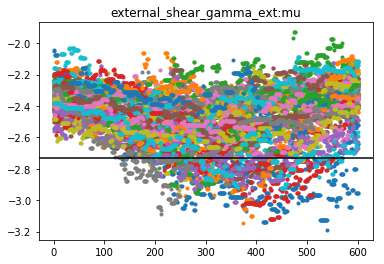

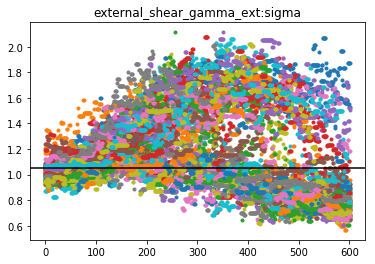

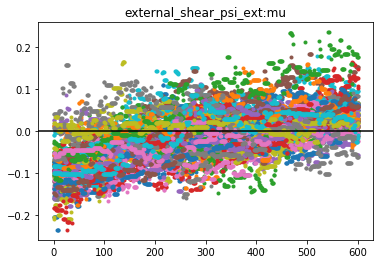

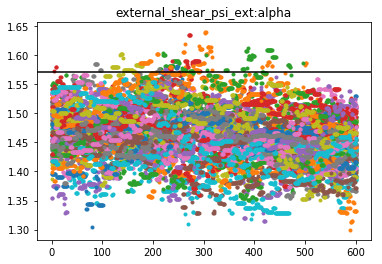

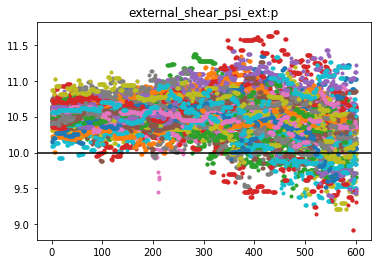

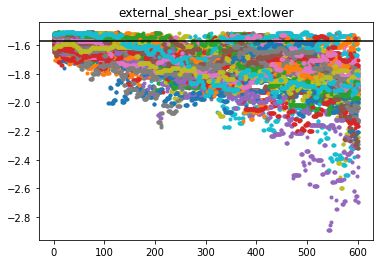

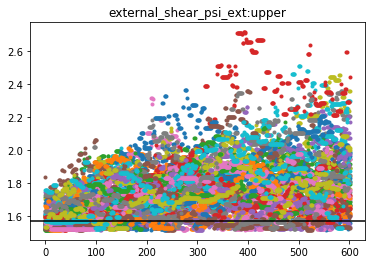

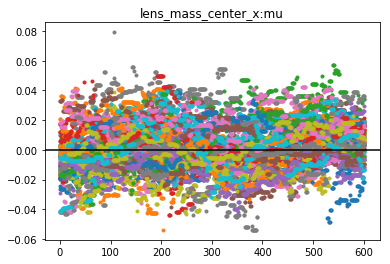

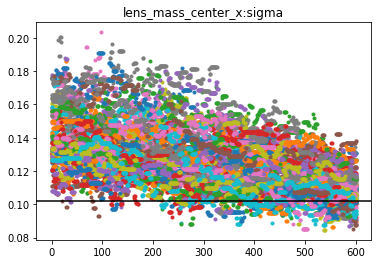

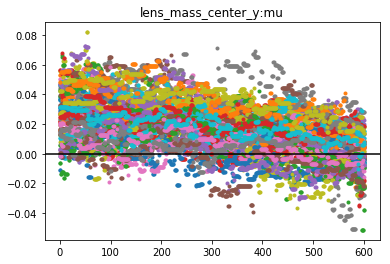

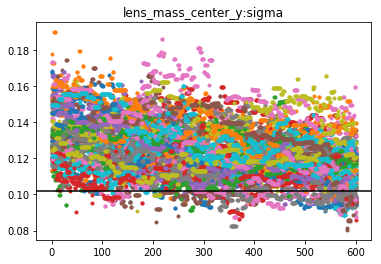

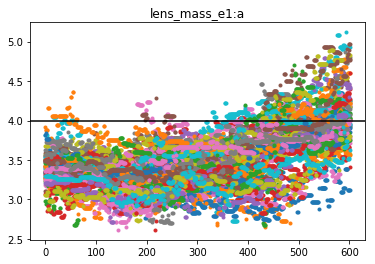

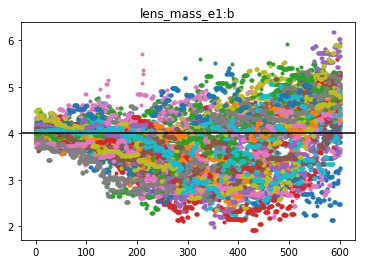

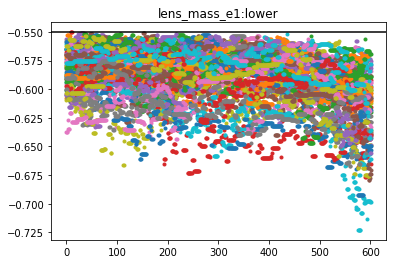

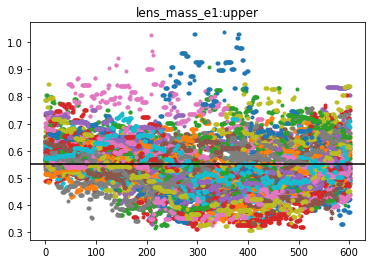

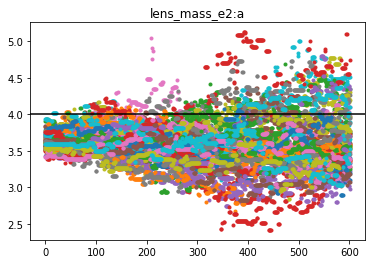

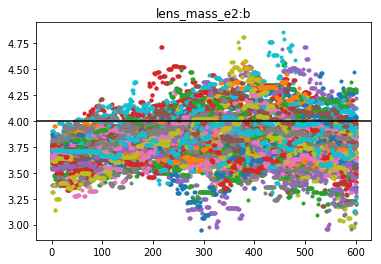

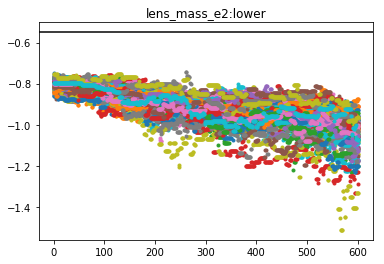

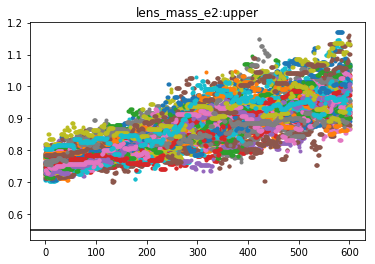

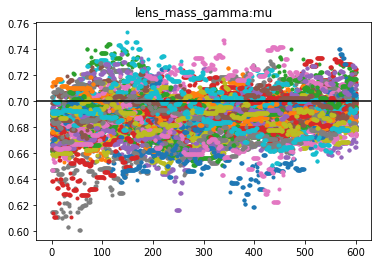

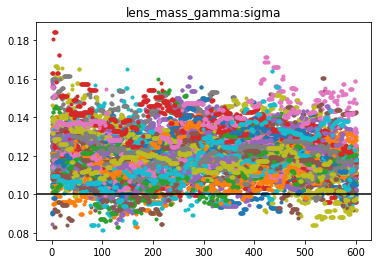

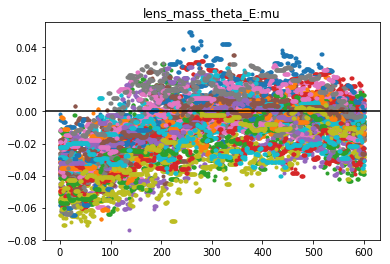

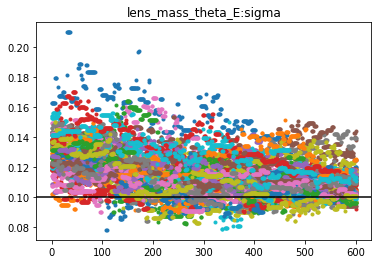

In [23]:
burnin = 600
chains = pickle.load(open('chains.p','rb'))[:,burnin:,:]
ci = 0
for chain in chains.T:
    plt.plot(chain,'.')
    plt.title(hier_infer.target_eval_dict['hyp_names'][ci])
    plt.axhline(hier_infer.interim_eval_dict['hyps'][ci],c='k')
    plt.show()
    ci += 1

In [24]:
chains = chains.reshape(-1,23)

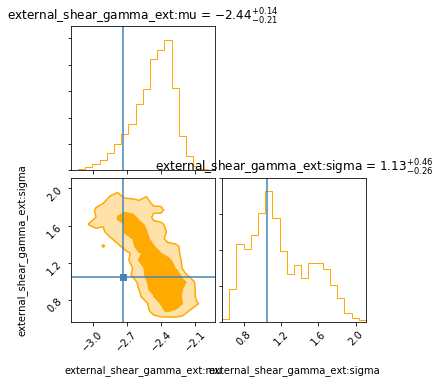

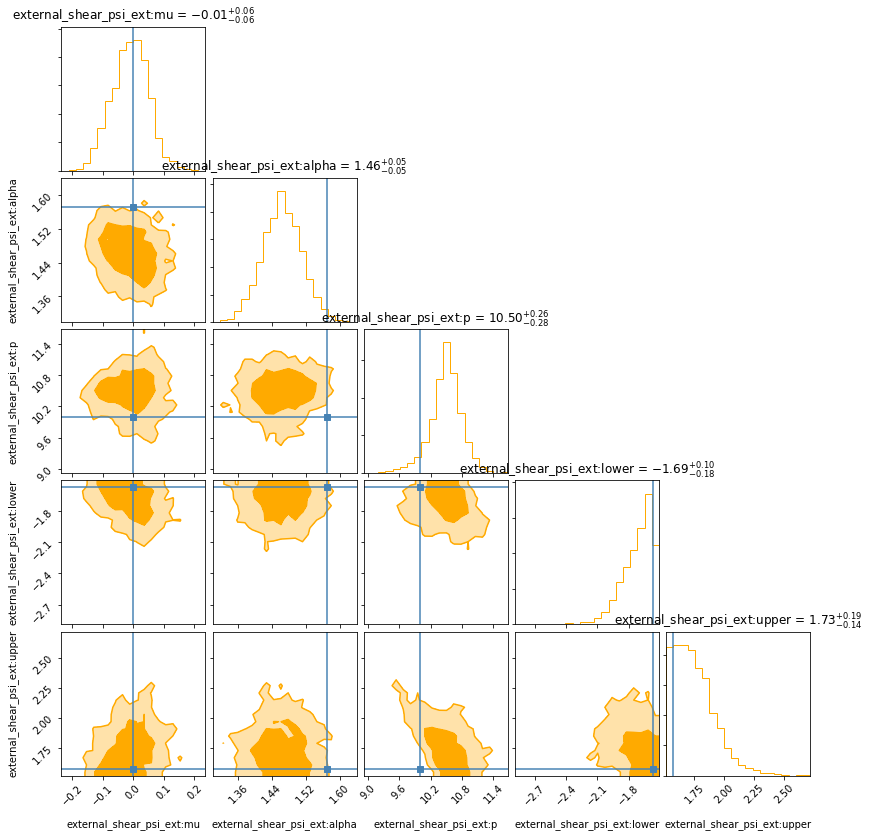

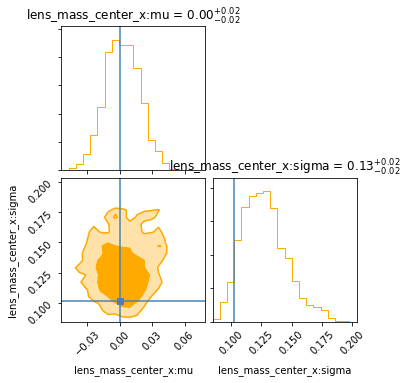

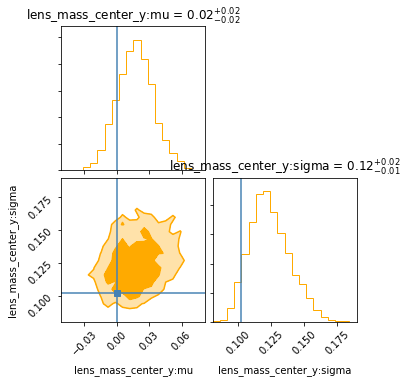

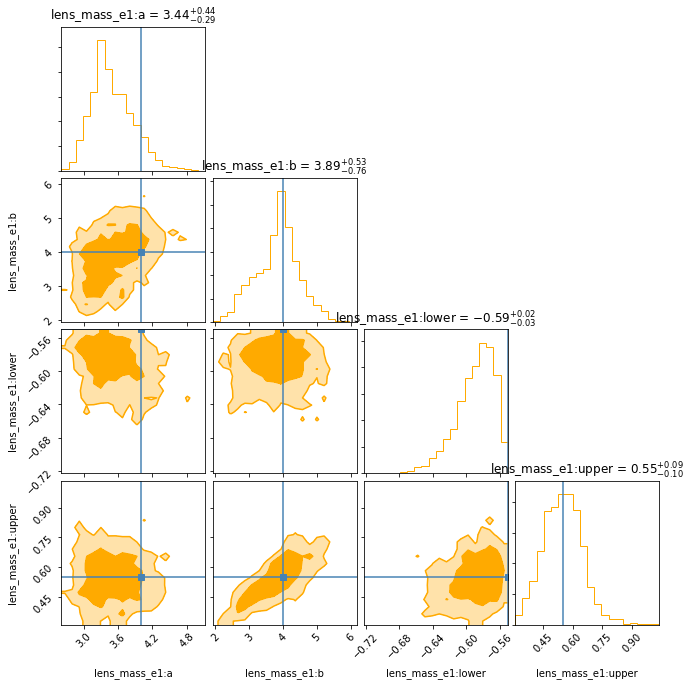

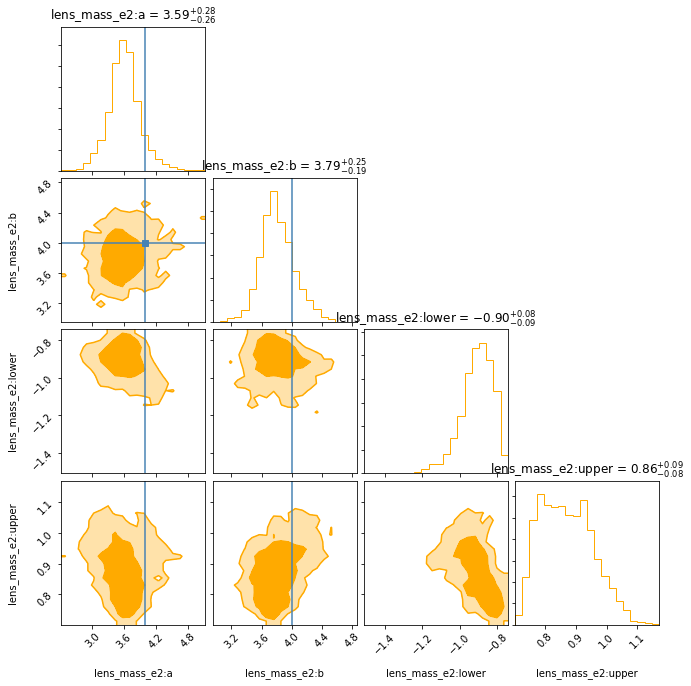

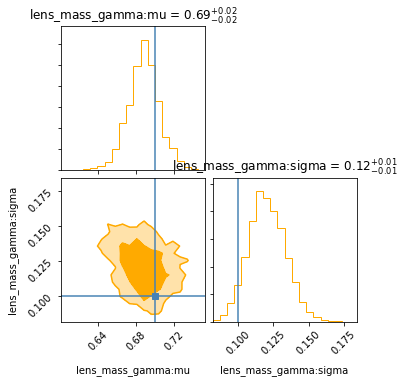

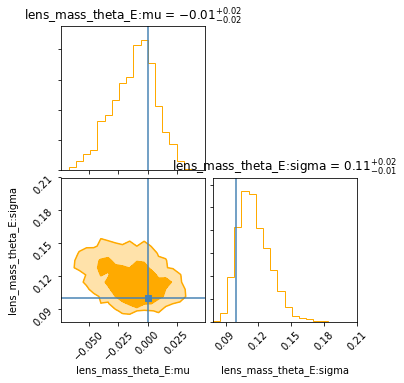

In [28]:
import corner
start = 0
cuts = [2,7,9,11,15,19,21,23]
for cut in cuts:
    corner.corner(chains[:,start:cut],labels=hier_infer.target_eval_dict['hyp_names'][start:cut],bins=20,
				show_titles=True, 
				plot_datapoints=False,label_kwargs=dict(fontsize=10),
				truths=hier_infer.interim_eval_dict['hyps'][start:cut],
                levels=[0.68,0.95],
                color='#FFAA00',
				fill_contours=True)
    start = cut
    plt.show()